# Cycle Consitency Audio Noise Filter (CycleGAN ANF)
<img src="images/G_model.png" width="100%">

This notebook, we're going to define and train a CycleGAN ANF to read in a raw audio sample from a set $X$ (voice mixed noise) and transform it so that it sound as if it belongs in set $Y$ (clear voice). Eventually, what we try to achieve is eliminating environmental sound (**noise filter**) and extracting only the speaker's voice.

>The objective will be to train generators that learn to transform a raw audio sample from domain $X$ into a raw audio file that sounds like it came from domain $Y$ (and vice versa). 

Examples of data in both sets are pictured below.

<img src="images/XY.png" width="60%">

###  Training Data

These audios samples do not come with labels, are stored in folders such as `X`, `Y`, `test_X` and `test_Y` in `data` folder. 

[Quoted from Cezannec]
CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A [CycleGANs](https://arxiv.org/abs/1703.10593) is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in the paper, the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

>**In this notebook we took that idea and apply to audios.**

### CycleGAN ANF and Notebook Structure

A **GAN** is made of two types of networks: **discriminators, and generators**. The discriminators are responsible for classifying audios as real or fake (for both $X$ and $Y$ kinds of audios). The generators are responsible for generating convincing, fake audios for both kinds of audios. 

>1. Load in the audio data using PyTorch's DataLoader class. 
2. Defining the CycleGAN ANF architecture, the discriminator and the generator models.
3. Define the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network.
4. Evaluate the model.


## 1: Load the Data

We'll first load in the training data, importing the necessary libraries to do so.

**Note:** This may take a while since we have to convert the audios file to compatible version and store in *RAM* for speed up the training. Especially when we want to test Different models.  

In [1]:
import numpy as np
import librosa
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

############################# 1. LOAD AUDIO Y ##############################
from LoadData import LoadandProcessData

batch_size = 16
Y_loader = LoadandProcessData(audio_dir = "./data/Y",
                                  batch_size = batch_size)
Y_generator, Y_batches = Y_loader.batch_generator()

print("Number of batches: ", Y_batches)


cuda
Number of batches:  670


In [2]:
############################# 1. LOAD AUDIO X ##############################


from LoadData import LoadandProcessData
X_loader = LoadandProcessData(audio_dir = "./data/X",
                                  batch_size = batch_size)
X_generator, X_batches = X_loader.batch_generator()

print("Number of latent batches: ", X_batches)
n_batches = min(Y_batches, X_batches)

Number of latent batches:  597


In [3]:
############################# 1. LOAD AUDIO Test_X ##############################


from LoadData import LoadandProcessData
Test_X_loader = LoadandProcessData(audio_dir = "./data/test_X",
                                  batch_size = batch_size)
Test_X_generator, Test_X_batches = Test_X_loader.batch_generator()

print("Number of latent batches: ", Test_X_batches)


Number of latent batches:  99


In [4]:
############################# 1. LOAD AUDIO Test Y ##############################


from LoadData import LoadandProcessData
Test_Y_loader = LoadandProcessData(audio_dir = "./data/test_Y",
                                  batch_size = batch_size)
Test_Y_generator, Test_Y_batches = Test_Y_loader.batch_generator()

print("Number of latent batches: ", Test_Y_batches)


Number of latent batches:  99


In [5]:
################## Helper Function - Plot Waveform #######################

import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline

def plotWave (filePath):
    y, sr = librosa.load(filePath, duration=10)
    plt.figure()
    plt.subplot(3, 1, 1)
    librosa.display.waveplot(y, sr=sr)
    plt.title('Monophonic')


In [6]:
##################### Helper scale function ############################

def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

---
## 2: Define The Model

A CycleGAN ANF is made of two discriminator and two generator networks.

### Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN ANF are convolutional 1D neural networks that attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. Picture Below ([WaveGAN](https://arxiv.org/pdf/1802.04208.pdf)) is showing a 2D filter differs from 1D filter:

<img src="images/1d_vs_2d.png" width="80%">

The discriminators have the following architecture:

<img src="images/D_model.png" width="80%">

This network taks a 1x16384 audios sample, and passes it through 5 1D-convolutional layers that downsample the audios by a factor of 4. The first four convolutional layers have Dropout and LeakyReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning the audio sample into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed audio. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src="images/G_model.png" width="90%">

This network sees a 1x16384 audio, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new audio.

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output.

>Detail inplementation of all models can be found in `WaveGAN_Models.py`

---
### Residual Blocks

Residual Block came from **ResNet50** for image classification, pictured below.

<img src="images/resnet_50.png" width="90%">
[Quoted from Cezannec]
ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src="images/resnet_block.png" width="40%">

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


>Detail inplementation of all models can be found in `WaveGAN_Models.py`

---
## Create network

Using the classes defined in `WaveGAN_Models.py`, we can define the discriminators and generators necessary to create a complete CycleGAN.

First, create two discriminators, one for checking if $X$ sample audios are real, and one for checking if $Y$ sample audios are real. Then the generators. Instantiate two of them, one for transforming a noisy into a clear audio and one for transforming a clear audio into a noisy audio.

In [26]:
##################### 2. CONSTRUCT G & D MODEL INSTANCES ######################
%load_ext autoreload
%autoreload 2
from torchsummary import summary
from WaveGAN_models import CycleGenerator, Discriminator

def create_model(g_conv_dim=32, d_conv_dim=32, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d=d_conv_dim)
    D_Y = Discriminator(d=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Models moved to GPU.


In [27]:
###################### helper function for printing the model architecture ########################

def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(25,), stride=(4,), padding=(11,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 128, kernel_size=(25,), stride=(4,), padding=(11,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(25,), stride=(4,), padding=(11,), bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_l

## 3: Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src="images/CycleGAN_loss.png" width="90%" height="90%">

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an audio, and the target value, 0 or 1, depending on whether it should classify that audio as fake or real. For example, for a *real* audio, `x`, we can train $D_X$ by looking at how close it is to recognizing and audio `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake audio that look like they belong to the set of $X$ audios but are based on real audios in set $Y$, and vice versa. We'll compute the "real loss" on those generated audios by looking at the output of the discriminator as it's applied to these _fake_ audios; this time, your generator aims to make the discriminator classify these fake audios as *real* audios. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed audio is, when compared to an original audio. 

Say you have a fake, generated audio, `x_hat`, and a real audio, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal audio `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real audios. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src="images/reconstruction_error.png" width="40%" height="40%">

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated audios, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

Take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.

In [9]:
########################### 3. DEFINE LOSS ##########################

def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed audios
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Define the Optimizers

Define how this model will update its weights. This uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. Take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [10]:
########################### 3. DEFINE Optimizers ##########################
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [11]:
# import save code
%load_ext autoreload
%autoreload 2
from helpers import checkpoint, save_sound_samples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Training a CycleGAN

When a CycleGAN ANF trains, and sees one batch of real audio samples from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real audios
2. Generate fake audios that sound like domain $X$ based on real audios in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake audios that sound like domain $X$ based on real audios in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ audios based on the fake $X$ audios generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ audios
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization


In [12]:
########################### 3. Training Cycle ##########################
from random import randrange

def training_loop(X_generator, Y_generator, Test_X_generator, Test_Y_generator, 
                  n_epochs=1000):
    
    print_every=50
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(Test_X_generator)
    test_iter_Y = iter(Test_Y_generator)

    # Get some fixed data from domains X and Y for sampling. These are audios that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0].float()
    #print(fixed_X.shape)
    fixed_Y = test_iter_Y.next()[0].float()
    #fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    #fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(X_generator)
    iter_Y = iter(Y_generator)
    n_batches = min(len(iter_X), len(iter_Y))
    #batches_per_epoch = 100
    for epoch in range(1, n_epochs+1):
        #j = 0
        #for i in range(batches_per_epoch - 1):
            #Reset iterators for each epoch
        if epoch % n_batches == 0:
            iter_X = iter(X_generator)
            iter_Y = iter(Y_generator)
            #j+=1
        audios_X = iter_X.next()[0] 
        #print(audios_X.shape)
        #audios_X = scale(audios_X) # make sure to scale to a range -1 to 1

        audios_Y = iter_Y.next()[0]
        #audios_Y = scale(audios_Y)

        # move audios to GPU if available (otherwise stay on CPU)
        #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        audios_X = audios_X.float().to(device)
        audios_Y = audios_Y.float().to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real audios
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real audios
        out_x = D_X(audios_X)
        D_X_real_loss = real_mse_loss(out_x)

        # Train with fake audios

        # 2. Generate fake audios that look like domain X based on real audios in domain Y
        fake_X = G_YtoX(audios_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)


        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()


        ##   Second: D_Y, real and fake loss components   ##

        # Train with real audios
        d_y_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real audios
        out_y = D_Y(audios_Y)
        D_Y_real_loss = real_mse_loss(out_y)

        # Train with fake audios

        # 2. Generate fake audios that look like domain Y based on real audios in domain X
        fake_Y = G_XtoY(audios_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X audios and reconstructed Y audios    ##
        g_optimizer.zero_grad()

        # 1. Generate fake audios that look like domain X based on real audios in domain Y
        fake_X = G_YtoX(audios_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(audios_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y audios and reconstructed X audios    ##

        # 1. Generate fake audios that look like domain Y based on real audios in domain X
        fake_Y = G_XtoY(audios_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(audios_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))


        sample_every=50
        # Save the generated samples
        if (epoch % sample_every) == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            rand = randrange(16) # pick random sample from test batch
            save_sound_samples(epoch, fixed_Y[rand].reshape(1,1,16384), fixed_X[rand].reshape(1,1,16384), 
                               G_YtoX, G_XtoY, 'generated_audios')
            G_YtoX.train()
            G_XtoY.train()

        # save models
        checkpoint_every=50
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y,'saved_models')

    return losses


In [13]:
n_epochs = 4000 

losses = training_loop(X_generator, Y_generator, Test_X_generator, Test_Y_generator, n_epochs=n_epochs)

Epoch [   50/ 4000] | d_X_loss: 0.3673 | d_Y_loss: 0.4672 | g_total_loss: 2.4149
Saved sample audio at:  generated_audios
Epoch [  100/ 4000] | d_X_loss: 0.3602 | d_Y_loss: 0.4983 | g_total_loss: 2.5677
Saved sample audio at:  generated_audios
Epoch [  150/ 4000] | d_X_loss: 0.3390 | d_Y_loss: 0.4768 | g_total_loss: 2.2476
Saved sample audio at:  generated_audios
Epoch [  200/ 4000] | d_X_loss: 0.5045 | d_Y_loss: 0.6188 | g_total_loss: 2.4079
Saved sample audio at:  generated_audios
Epoch [  250/ 4000] | d_X_loss: 0.4504 | d_Y_loss: 0.5566 | g_total_loss: 2.0337
Saved sample audio at:  generated_audios
Epoch [  300/ 4000] | d_X_loss: 0.4632 | d_Y_loss: 0.4789 | g_total_loss: 2.0635
Saved sample audio at:  generated_audios
Epoch [  350/ 4000] | d_X_loss: 0.5298 | d_Y_loss: 0.4435 | g_total_loss: 2.4764
Saved sample audio at:  generated_audios
Epoch [  400/ 4000] | d_X_loss: 0.4124 | d_Y_loss: 0.4221 | g_total_loss: 2.6784
Saved sample audio at:  generated_audios
Epoch [  450/ 4000] | d_

Epoch [ 3450/ 4000] | d_X_loss: 0.1748 | d_Y_loss: 0.3198 | g_total_loss: 2.5938
Saved sample audio at:  generated_audios
Epoch [ 3500/ 4000] | d_X_loss: 0.0686 | d_Y_loss: 0.3255 | g_total_loss: 2.6215
Saved sample audio at:  generated_audios
Epoch [ 3550/ 4000] | d_X_loss: 0.0997 | d_Y_loss: 0.2685 | g_total_loss: 2.3657
Saved sample audio at:  generated_audios
Epoch [ 3600/ 4000] | d_X_loss: 0.1077 | d_Y_loss: 0.4127 | g_total_loss: 2.3970
Saved sample audio at:  generated_audios
Epoch [ 3650/ 4000] | d_X_loss: 0.0698 | d_Y_loss: 0.2254 | g_total_loss: 2.6744
Saved sample audio at:  generated_audios
Epoch [ 3700/ 4000] | d_X_loss: 0.0752 | d_Y_loss: 0.3233 | g_total_loss: 2.5221
Saved sample audio at:  generated_audios
Epoch [ 3750/ 4000] | d_X_loss: 0.0570 | d_Y_loss: 0.3056 | g_total_loss: 2.8410
Saved sample audio at:  generated_audios
Epoch [ 3800/ 4000] | d_X_loss: 0.0524 | d_Y_loss: 0.3567 | g_total_loss: 2.7167
Saved sample audio at:  generated_audios
Epoch [ 3850/ 4000] | d_

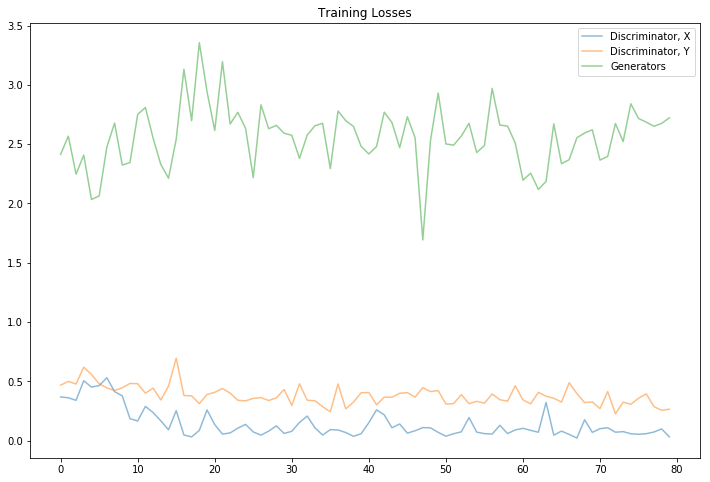

In [14]:
########################### 4. Plot the losses ##########################

fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios
Saved sample audio at:  eval_audios


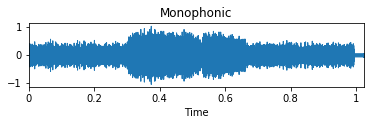

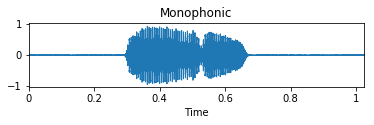

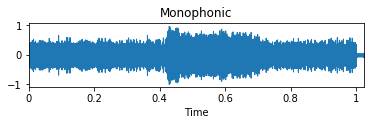

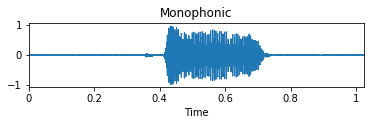

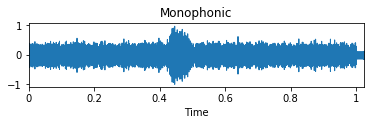

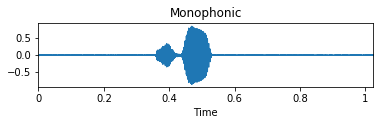

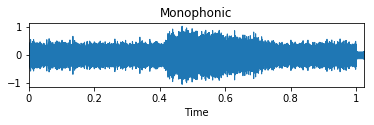

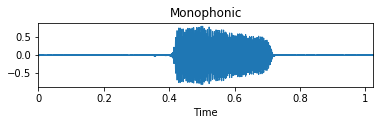

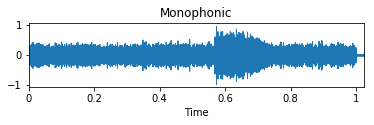

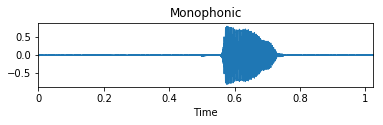

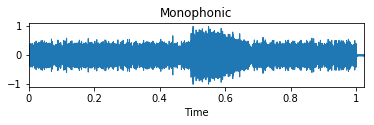

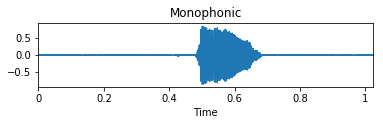

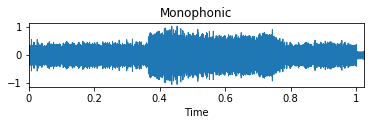

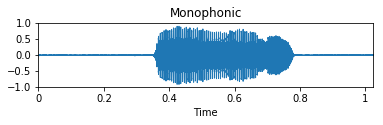

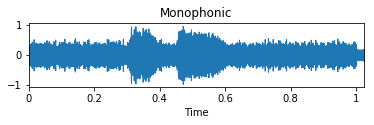

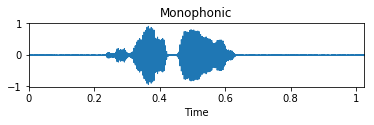

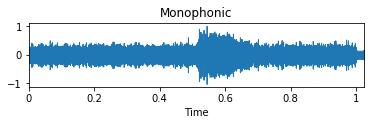

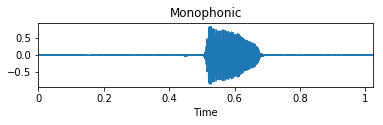

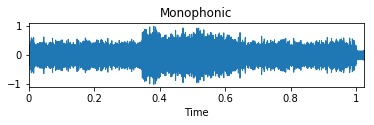

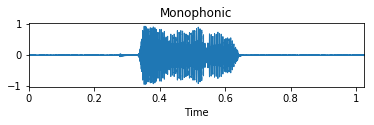

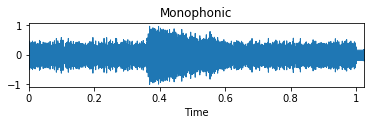

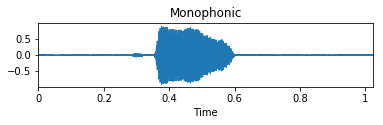

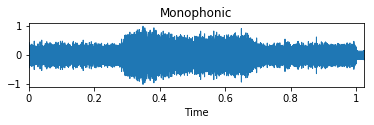

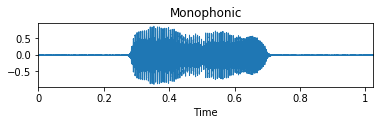

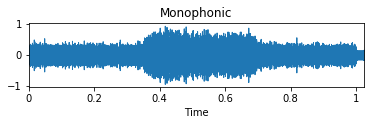

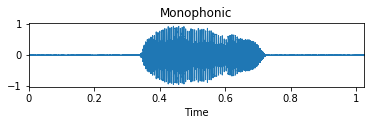

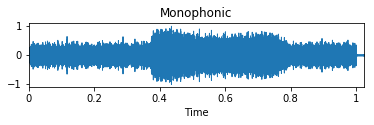

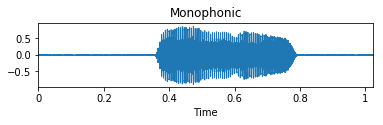

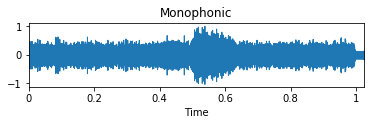

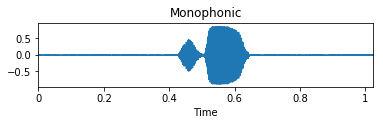

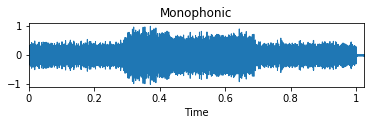

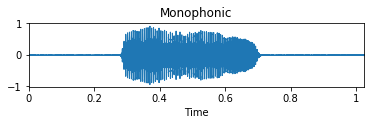

In [25]:
########################### 4. Evaluation ##########################



test_iter_X = iter(Test_X_generator)
test_iter_Y = iter(Test_Y_generator)

# Get some fixed data from domains X and Y for sampling. 
fixed_X = test_iter_X.next()[0].float().cpu()
#print(fixed_X.shape)
fixed_Y = test_iter_Y.next()[0].float().cpu()

G_XtoY.load_state_dict(torch.load("saved_models/G_XtoY_2400.pkl")) 
G_YtoX.load_state_dict(torch.load("saved_models/G_YtoX_2400.pkl")) 
G_XtoY.eval()
G_YtoX.eval()

for i in range(batch_size): 
    save_sound_samples(2400+i, fixed_Y[i].reshape(1,1,16384), fixed_X[i].reshape(1,1,16384), 
                               G_YtoX, G_XtoY, 'eval_audios')
    plotWave('eval_audios/FixedX_Epoch_'+str(2400+i)+'.wav')
    plotWave('eval_audios/XtoY_Epoch_'+str(2400+i)+'.wav')